In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('data/obecity_prediction.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

Dataset Shape: (2111, 17)

Data Types:
 Gender             object
Age               float64
Height            float64
Weight            float64
family_history     object
FAVC               object
FCVC              float64
NCP               float64
CAEC               object
SMOKE              object
CH2O              float64
SCC                object
FAF               float64
TUE               float64
CALC               object
MTRANS             object
Obesity            object
dtype: object

Missing Values:
 Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

First few rows of the dataset:


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# Binning of FAF FCVC CH20 TUE
fcvc_labels = {
    1: 'Never',
    2: 'Sometimes',
    3: 'Always'
}

df['FCVC_cat'] = df['FCVC'].round().astype(int).map(fcvc_labels)

ch2o_labels = {
    1: '<1L',
    2: '1-2L',
    3: '>2L'
}

df['CH2O_cat'] = df['CH2O'].round().astype(int).map(ch2o_labels)

faf_labels = {
    0: 'I do not',
    1: '1 - 2 days',
    2: '2 - 4 days',
    3: '4 - 5 days'
}

df['FAF_cat'] = df['FAF'].round().astype(int).map(fcvc_labels)

tue_labels = {
    0: '0-2h',
    1: '3-5h',
    2: '>5h'
}

df['TUE_cat'] = df['TUE'].round().astype(int).map(fcvc_labels)

In [10]:
# Create BMI feature
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

df[]

# Encode categorical variables
le = LabelEncoder()
categorical_columns = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 
                       'CALC', 'MTRANS', 'Obesity', 'FAF_cat', 'TUE_cat', 'FCVC_cat', 'CH2O_cat']

for column in categorical_columns:
    df[column + '_encoded'] = le.fit_transform(df[column])

# Display new features
print("New features added:")
print(df['BMI'].describe())

New features added:
count    2111.000000
mean       29.700159
std         8.011337
min        12.998685
25%        24.325802
50%        28.719089
75%        36.016501
max        50.811753
Name: BMI, dtype: float64


In [11]:
# Select features for the model
feature_columns = [col for col in df.columns if col.endswith('_encoded') and col != 'Obesity_encoded']
feature_columns.extend(['BMI', 'Age', 'NCP'])

X = df[feature_columns]
y = df['Obesity_encoded']

# Split the data to 60% training, 20% validation and 20% test
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [13]:
knn.score(X_val, y_val)

0.943127962085308

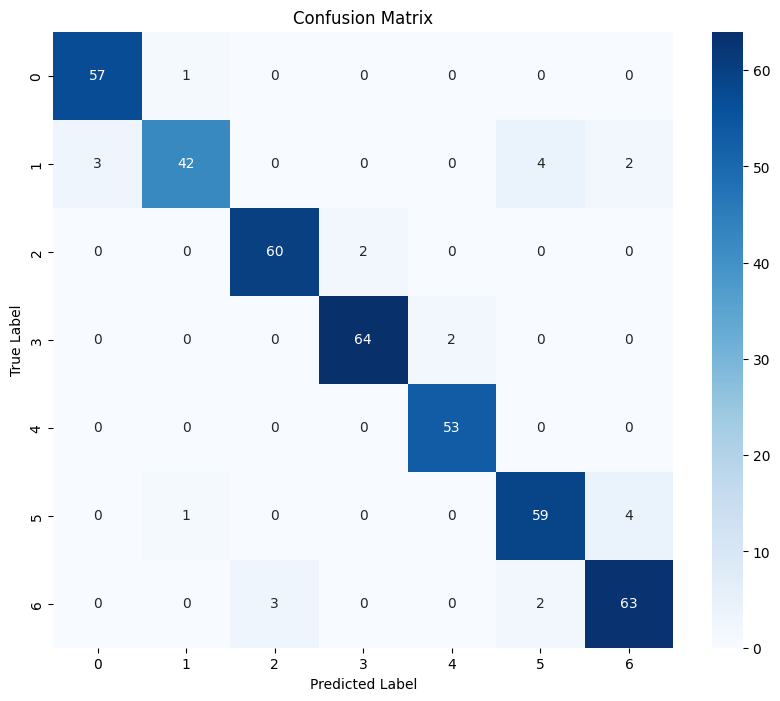

In [14]:
# Make predictions
y_pred = knn.predict(X_val)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        58
           1       0.95      0.82      0.88        51
           2       0.95      0.97      0.96        62
           3       0.97      0.97      0.97        66
           4       0.96      1.00      0.98        53
           5       0.91      0.92      0.91        64
           6       0.91      0.93      0.92        68

    accuracy                           0.94       422
   macro avg       0.94      0.94      0.94       422
weighted avg       0.94      0.94      0.94       422



In [16]:
perm_importance = permutation_importance(knn, X_val, y_val, scoring='accuracy')
feature_importance = perm_importance.importances_mean
df_features = pd.DataFrame(columns = ('Feature', 'Score'))

for i, score in enumerate(feature_importance):
    feature_name = X_val.columns[i]
    new_row = {"Feature": feature_name, "Score": score}
    df_features.loc[len(df_features)] = new_row

df_features

,Feature,Score
0,Gender_encoded,0.002844
1,family_history_encoded,0.002844
2,FAVC_encoded,0.003791
3,CAEC_encoded,0.002844
4,SMOKE_encoded,0.000000
5,SCC_encoded,0.000000
6,CALC_encoded,0.010427
7,MTRANS_encoded,0.017536
8,FAF_cat_encoded,0.014218
9,TUE_cat_encoded,0.011848


In [17]:
df_features.sort_values(['Score'], ascending = False, inplace = True)
top_ten_features = df_features.head(10)
top_ten_features

,Feature,Score
12,BMI,0.734123
13,Age,0.145972
7,MTRANS_encoded,0.017536
8,FAF_cat_encoded,0.014218
9,TUE_cat_encoded,0.011848
11,CH2O_cat_encoded,0.010900
6,CALC_encoded,0.010427
14,NCP,0.006635
10,FCVC_cat_encoded,0.005213
2,FAVC_encoded,0.003791


In [18]:
# Train second model using top 10 features
X_train_selected = X_train[top_ten_features["Feature"]]
X_val_selected = X_val[top_ten_features["Feature"]]
X_test_selected = X_test[top_ten_features["Feature"]]

second_knn = KNeighborsClassifier(n_neighbors=5)
second_knn.fit(X_train_selected, y_train)

KNeighborsClassifier()

In [19]:
second_knn.score(X_val_selected, y_val)

0.9383886255924171

In [20]:
second_knn.score(X_test_selected, y_test)

0.9196217494089834

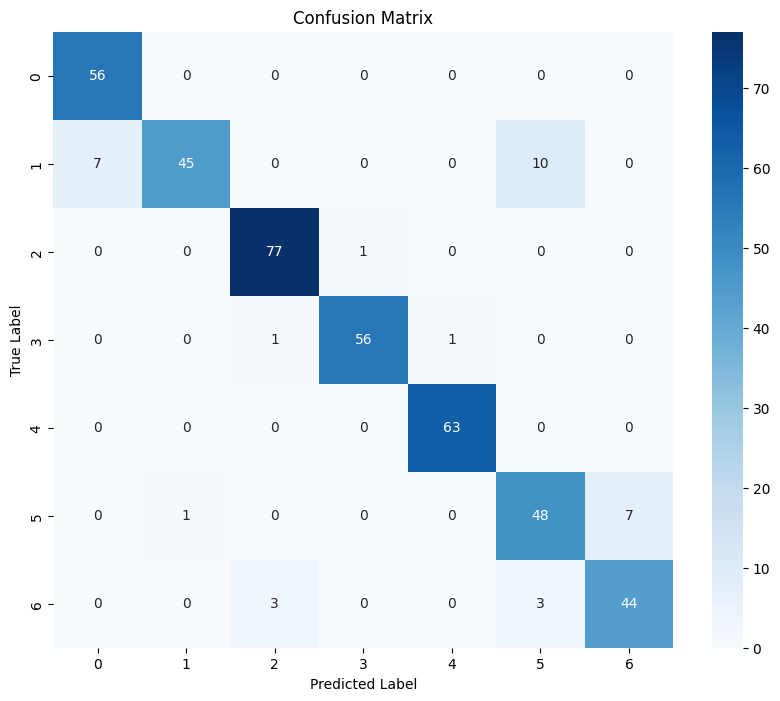

In [21]:
# Final Evaluation
final_y_pred = second_knn.predict(X_test_selected)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, final_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
print(classification_report(y_test, final_y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        56
           1       0.98      0.73      0.83        62
           2       0.95      0.99      0.97        78
           3       0.98      0.97      0.97        58
           4       0.98      1.00      0.99        63
           5       0.79      0.86      0.82        56
           6       0.86      0.88      0.87        50

    accuracy                           0.92       423
   macro avg       0.92      0.92      0.91       423
weighted avg       0.92      0.92      0.92       423



In [23]:
print(accuracy_score(y_test, final_y_pred))

0.9196217494089834
